<a href="https://colab.research.google.com/github/natdosan/cogs138project/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Alzheimer's Disease With fMRI Data 

Authors: Nathaniel del Rosario, Vladimir Em, Yosen Lin

# Introduction & Background

### Overview

With our dataset of square fMRI images, we did some minor preprocessing and used a CNN to essentially learn different feature mappings of the image to predict / classify Alzheimers Disease through demented and non-demented training examples. Before training, we did some EDA to learn more about the data through plotting some features about the data like pixel intensity distributin and principal component analysis. Our model performed particularly well despite being pretty simple thanks to some key factors: B/W nature of the images, data being mostly in the correct format needed, and proper optimizer & loss function as well as model architecture / design choices. We then performed KFold Cross Validation to verify that our model had not overfit to the data, of which the results were consistent.

### Research Question

 Can we use fMRI scans of demented patients to predict / classify Alzheimers Disease among humans through supervised methods? More specifically, can we use a CNN, the previous state of the art method for computer vision (before Vision Transformers) to learn feature mappings such as edges, corners, curves, and more complex features and representations of these scans, specifically their to accurately predict / classify Alzheimer's Disease.




### Background & Prior Work

### Context

MRI is a widely used method for extracting data/insight around patients’ brains, and can provide a large amount of information that can aid in tasks such as diagnosis, prediction, and overall observation of brain activity under different conditions. With respect to MRI data for the purpose of MCI & AD, this question is important as it helps in the advancement of new technologies / methods for predicting these conditions earlier on, thus possibly helping prevent these conditions in the future, earlier. This is interesting / noteworthy because oftentimes it is too late once a patient receives a diagnosis, so being able to predict a diagnosis early on before the condition is severe is a huge advancement in human health. 

### 1
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8083897/

The most relevant recent paper we could find was the following, in which researchers used Convolutional Neural Network (CNN) to detect Alzheimer’s disease based off MRI images. Specifically, their main goal was to introduce transfer learning from a dataset of 2D images to 3D CNNs. There were 2 approaches: a Sequence-based model and a slice-based model.

The Slice-based model featured a CNN that reads in 2D MRI Slices from originally 3D MRI volumes. This approach neglected the connection among 2D image slices in an MRI volume (only considering each slice individually and not in relation to the slice before and after.)

The Sequence based model feature a CNN similar to the Slice based model as well as a Recurrent Neural Network that did consider the slices 'above' and 'below' it.

The results were that the sequence-based was more accurate by 2% and a voxel-based method with transfer learning (3D CNN) considerably improved the accuracy.

Dataset: 

The paper uses MRI data containing 132 subjects per class (Alzheimer's Disease [AD] and Normal Controls [NC]), aged 55 to 90 years, collected across 50 states. Data Preprocessing MRI dimensions of 79×95×79. The dataset involved 2D slices extracted from 3D MRI volumes, forming 24 RGB coronal images, 19 RGB sagittal images, and 16 RGB axial images by stacking three adjacent slices. Data augmentation techniques such as random translation, scaling, reflection, noise injection, rotation, blurring, cropping, and gamma correction were applied to enhance data variability. This ensures high quality output.

Relation to our Analysis:

We used 6400 B/W fMRI images with no given masks / extracted features /layers from CNNs. We converted the images to numpy array, and simplified the problem to Demented and Non-Demented classification only to address the class imbalance issues.

Our goal is to closely follow the Slice-Based model approach as our data closely matches the format of this  approach.

### 2
Bellezza M, di Palma A, Frosini A. Predicting Conversion from Mild Cognitive Impairment to Alzheimer’s Disease Using K-Means Clustering on MRI Data. Information. 2024; 15(2):96. https://doi.org/10.3390/info15020096

This study is different to the first where K-means is used in a supervised manner instead of an unsupervised manner. Here, k was hard set to 2 for a Binary classification task similar to the first paper where researchers predict demented and non-demented cases.

The data used in preparation of this article was obtained from the Alzheimer’s Disease Neuroimaging Initiative (ADNI) database. It also featured MRI scans of color which were 2D slices of 3D MRI volumes.

Relation to our Analysis:

The data in this study is also similar to our dataset, so we initially hypothesized a K-Means supervised approach although later switching to follow the CNN based approach in the first study.

### 3

Qiao, Ju et al. “Data on MRI brain lesion segmentation using K-means and Gaussian Mixture Model-Expectation Maximization.” Data in brief vol. 27 104628. 10 Oct. 2019, doi:10.1016/j.dib.2019.104628. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6820303/

This study is different to the second where K-means is used in a supervised manner instead of an unsupervised manner. It differs where segmentation is also a part of the approach, and Guassian Mixture models are used additionally which provide a softer labelling criteria by introducing probability to each class instead of hard-assigning each label.

The data were also 2D fMRI scans from the ischemic stroke lesion segmentation online database. In the case of segmentation data, these were generated using K-means and Gaussian Mixture Model-Expectation Maximization algorithms on the original data.

Relation to our Analysis:

The data in this study is also similar to our dataset, and the incorporation of segmentation ultimately led us to the idea. and further research of using a CNN instead of the K-Means approach in study 2.

### Hypothesis

  We hypothesize that because of the simple nature of these fMRI scans, specifically the square dimensions and uniform centering of the brain as well as the many different advancements in CNN architecture / computer vision methods ***we can create a model that generalizes to our data well and predicts Alzheimers better than the baseline metric of random guessing / 50 - 50 guessing***.

  We further discuss the specifics of our analysis and model design choices in the following analysis


# Data Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# import essentials
import scipy
import pandas as pd
import numpy as np

# methods & metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score, classification_report, confusion_matrix
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold

# util
import PIL
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import glob
import warnings
import os
from util import dataloader

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Wrangling
 ❏    Pull your data into Python and explain steps taken to isolate the data you need

Nate created a dataloader function so that we can load in all the data into separate arrays as well as see the number of examples in each to help assess any class imbalances. As seen below, all images are of 128 x 128 pixels, and there are two classes which make up the majority of the examples, non demented and very mildly demented patients. This result is not too surprising as we would expect a majority of patients to not have mild / moderate demensia.

In [2]:
# for collab w/ virtual machine for training
#non_demented = dataloader('/content/drive/MyDrive/Colab/final_project/data/Non_Demented')
#very_mild_demented = dataloader('/content/drive/MyDrive/Colab/final_project/data/Very_Mild_Demented')
#mild_demented = dataloader('/content/drive/MyDrive/Colab/final_project/data/Mild_Demented')
#moderate_demented = dataloader('/content/drive/MyDrive/Colab/final_project/data/Moderate_Demented')

# for local machine
non_demented = dataloader('data/Non_Demented')
very_mild_demented = dataloader('data/Very_Mild_Demented')
mild_demented = dataloader('data/Mild_Demented')
moderate_demented = dataloader('data/Moderate_Demented')

Loaded 3200 images with shape (128, 128)
Loaded 2240 images with shape (128, 128)
Loaded 896 images with shape (128, 128)
Loaded 64 images with shape (128, 128)


We could make two datasets, one where we keep the original class distribution, and one where we under/oversample the data set to create an even distribution. Another solution would be to instead combine all demented examples into one class, that way we predict demented / non-demented. ***This is not only better for our approach as it simplifies the problem, but also allows us to generate a model that learns different demented stages, which then causes it to generalize better to different stages of dementia and therefore predict Alzheimers earlier and with better accuracy.***

### Visualization
 ❏    Include at least three visualizations

 ❏    Clearly label all axes on plots

 ❏    Type of all plots appropriate given data displayed

 ❏    Interpretation of each visualization included in text


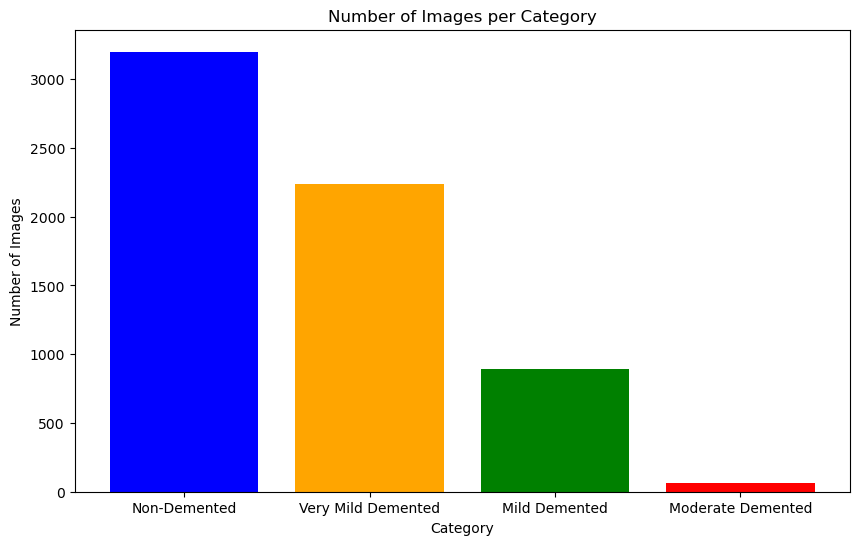

In [3]:
categories = ['Non-Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented']
counts = [len(non_demented), len(very_mild_demented), len(mild_demented), len(moderate_demented)]

plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=['blue', 'orange', 'green', 'red'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.show()

Here we use a simple bar chart to show the raw class distribution for the images. As we can see, Non-Demented and Very Mild-Demented make up the majority of the exmamples. We will address this later.

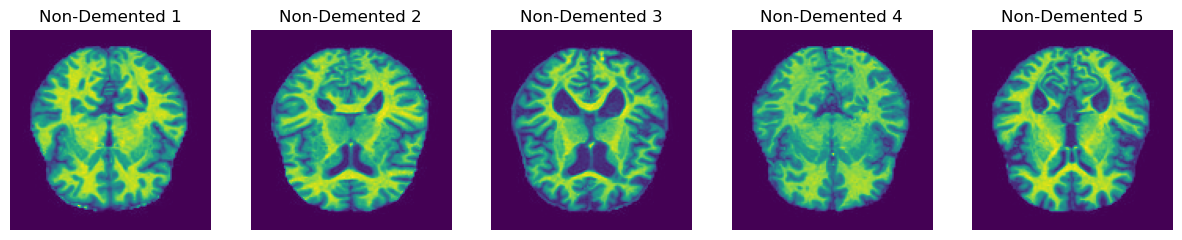

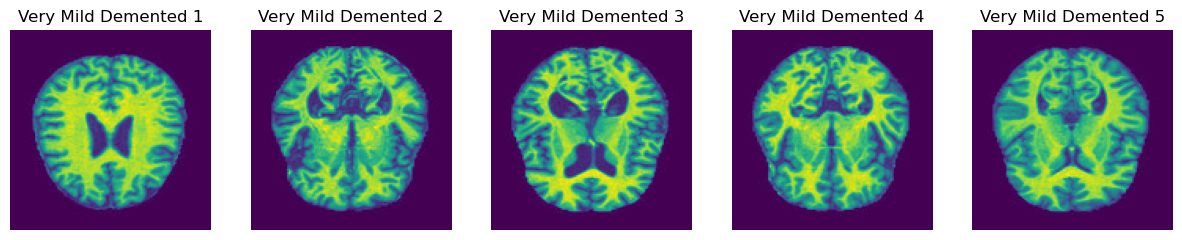

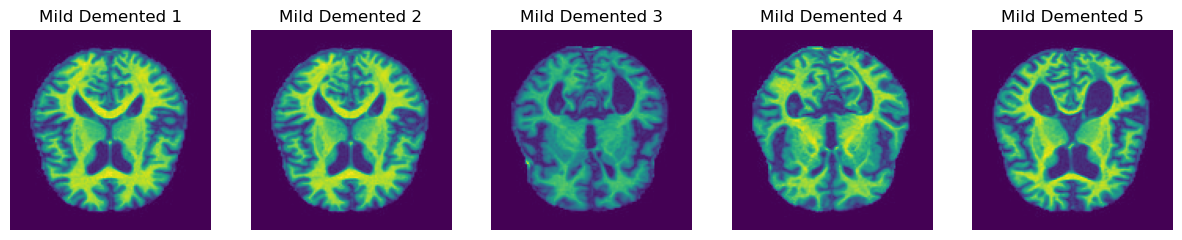

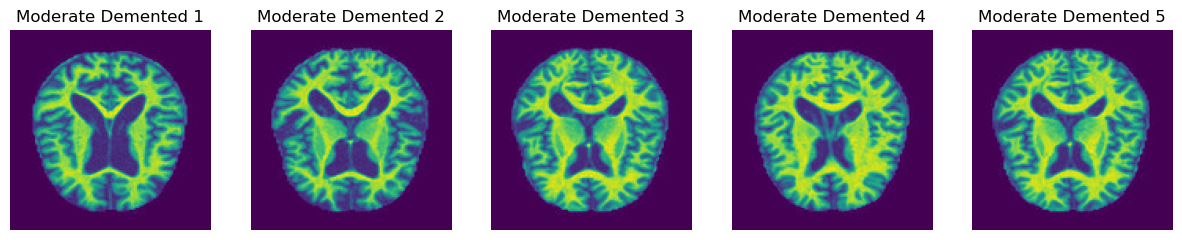

In [4]:
def plot_example_images(images, category, n=5):
    """
    Plots examples from classes

    Parameters
    ----------
    images : numpy array
        fMRI data
    category : str
        the class label
    """
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        plt.title(f'{category} {i+1}')
        plt.axis('off')
    plt.show()

plot_example_images(non_demented, 'Non-Demented')
plot_example_images(very_mild_demented, 'Very Mild Demented')
plot_example_images(mild_demented, 'Mild Demented')
plot_example_images(moderate_demented, 'Moderate Demented')

Here we show example fMRI scans in color to show the different layers at which the brain scans occured. It is important to note that in the original dataset these are black and white scans. Showing these scans in color allows the reader to easier see the different intensities in pixel 'brightness' as opposed to black and white.

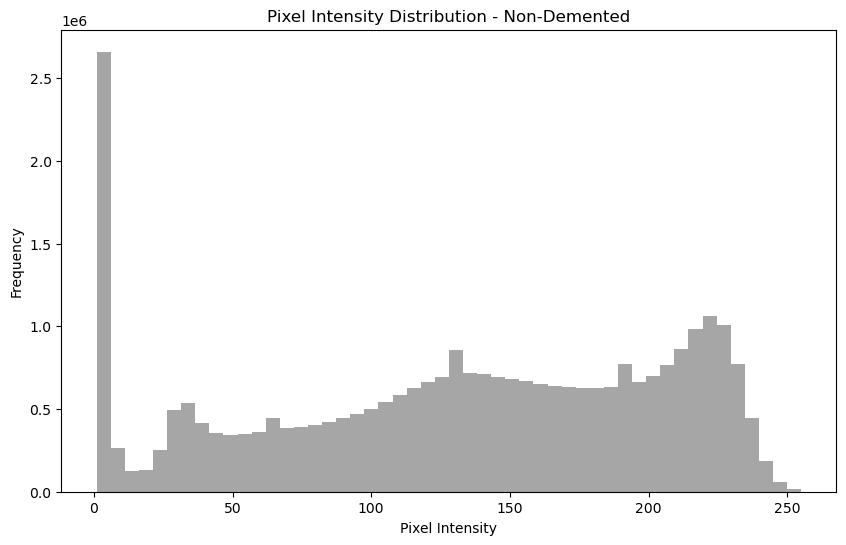

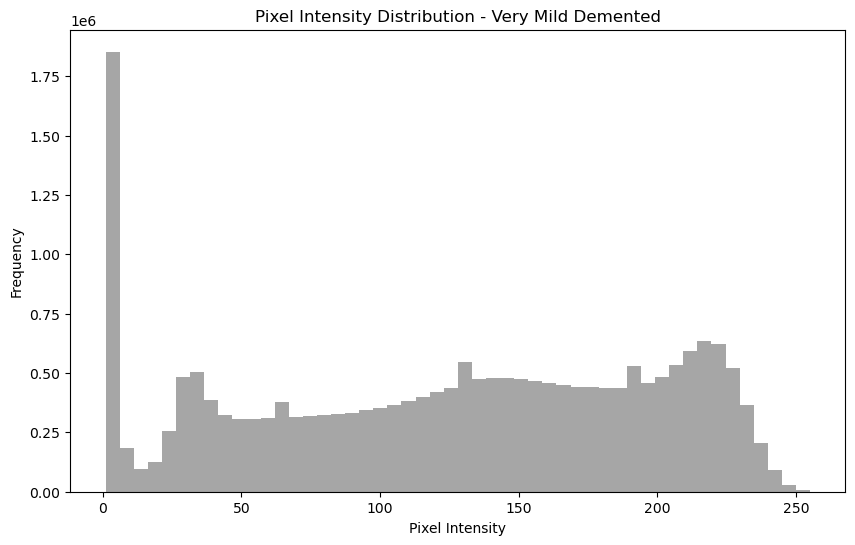

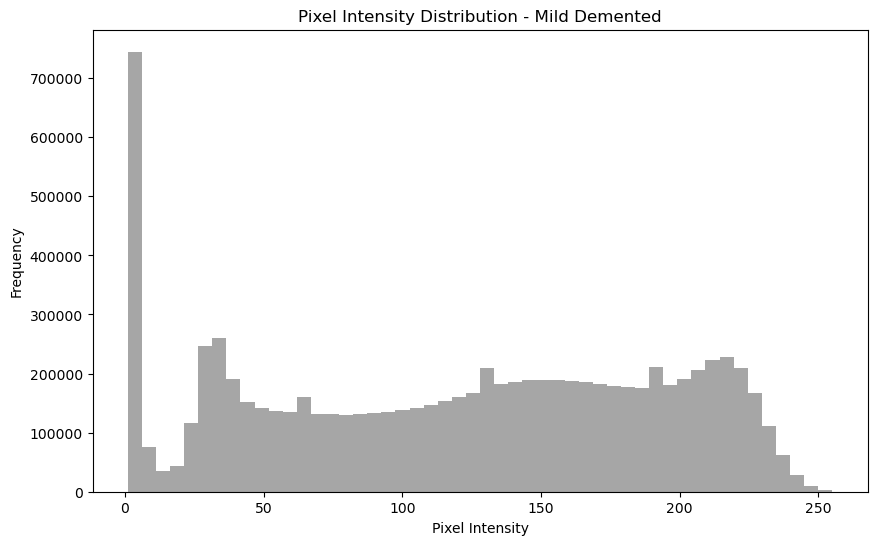

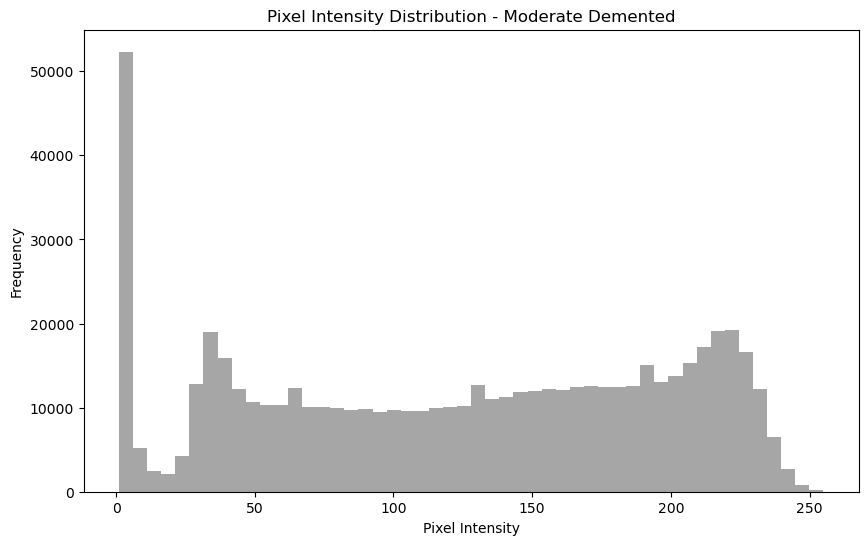

In [5]:
def plot_intensity_distribution(images, category):
    """
    Shows pixel intensity distribution

    Parameters
    ----------
    images : numpy array
        fMRI data
    category : str
        the class label
    """
    plt.figure(figsize=(10, 6))
    pixel_values = images.flatten()
    pixel_values = pixel_values[pixel_values != 0]
    plt.hist(pixel_values, bins=50, color='gray', alpha=0.7)
    plt.title(f'Pixel Intensity Distribution - {category}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

plot_intensity_distribution(non_demented, 'Non-Demented')
plot_intensity_distribution(very_mild_demented, 'Very Mild Demented')
plot_intensity_distribution(mild_demented, 'Mild Demented')
plot_intensity_distribution(moderate_demented, 'Moderate Demented')


Here we again use a bar chart, but this time plotting the pixel intensity distribution for each class. Across all classes, we see 0, or black pixels make up a majority, with various shades of white / gray following a similar distribution for each of the classes.

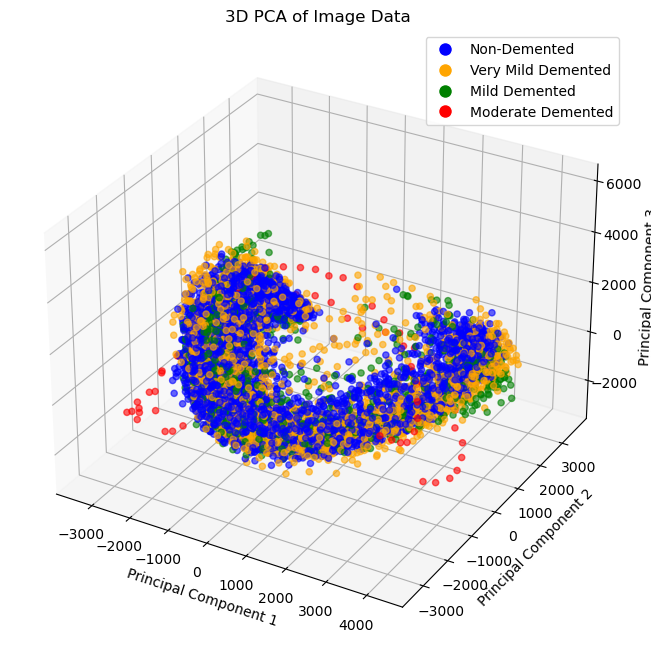

In [6]:
def apply_pca(images, n_components=3):
    """
    Function to apply PCA

    Parameters
    ----------
    images : numpy array
        fMRI data
    n_components : int
        num of components (less than k)

    Returns
    -------
    principal components
    """
    reshaped_images = images.reshape(images.shape[0], -1)
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(reshaped_images)
    return principal_components

# Apply PCA to each category
non_demented_pca = apply_pca(non_demented)
very_mild_demented_pca = apply_pca(very_mild_demented)
mild_demented_pca = apply_pca(mild_demented)
moderate_demented_pca = apply_pca(moderate_demented)

# Combine all PCA results and create a corresponding label array
all_pca = np.concatenate((non_demented_pca, very_mild_demented_pca, mild_demented_pca, moderate_demented_pca), axis=0)
labels = (['Non-Demented'] * len(non_demented) +
          ['Very Mild Demented'] * len(very_mild_demented) +
          ['Mild Demented'] * len(mild_demented) +
          ['Moderate Demented'] * len(moderate_demented))

# Map labels to colors
label_color_map = {
    'Non-Demented': 'blue',
    'Very Mild Demented': 'orange',
    'Mild Demented': 'green',
    'Moderate Demented': 'red'
}

colors = [label_color_map[label] for label in labels]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each category
ax.scatter(all_pca[:, 0], all_pca[:, 1], all_pca[:, 2], c=colors, alpha=0.6)

ax.set_title('3D PCA of Image Data')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in label_color_map.values()]
ax.legend(handles, label_color_map.keys())

plt.show()


Lastly, we performed PCA which produced a 3D ring like trend for all classes except for the moderate demented class. We did this out of curiousity to better visualize the data initially when attempting K-Means to label our data. However our approach ended up changing but still decided to keep the figure because of the noteworthy ring structure.

### Model Architecture
CNN - takes in square image
- All activation functions are ReLU, applied at end of every layer to ensure non-linearity
- Adam Optimizer for reduce computation complexity, efficient memory usage, incorporating momentum as opposed to native SGD
- Mini-Batch SGD for training to increase throughput
- Categorical CE loss function since we are dealing with classification

Layer 1 : 3 x 3 kernel, introduce non-linearity

Layer 2: Max Pooling, non-linearity

Layer 3: 3 x 3 kernel, non-linearity

Layer 4: Max Pooling, non-linearity

Then we flatten the input to Layer 5

Layer 5: Dense, non-linearity

Then we perform dropout which will help our model generalize better to data and prevent overfitting

Softmax Layer: Finally we have a softmax at the end for handling the logits and giving us our predictions



We tried many different architectures, and found that applying max pooling more than once significantly improved performance. We hypothesize that because of the large amount of black pixels and background, when we perform max pooling, it rids these pixel distribution imbalances and allows for features to be learned better.

Epoch 1/10
160/160 [==============================] - 4s 19ms/step - loss: 0.6740 - accuracy: 0.5654 - val_loss: 0.6187 - val_accuracy: 0.6703
Epoch 2/10
160/160 [==============================] - 3s 16ms/step - loss: 0.5919 - accuracy: 0.7000 - val_loss: 0.5536 - val_accuracy: 0.7125
Epoch 3/10
160/160 [==============================] - 3s 16ms/step - loss: 0.5415 - accuracy: 0.7361 - val_loss: 0.5146 - val_accuracy: 0.7445
Epoch 4/10
160/160 [==============================] - 3s 16ms/step - loss: 0.4723 - accuracy: 0.7719 - val_loss: 0.4433 - val_accuracy: 0.7570
Epoch 5/10
160/160 [==============================] - 3s 16ms/step - loss: 0.4021 - accuracy: 0.8111 - val_loss: 0.3584 - val_accuracy: 0.8273
Epoch 6/10
160/160 [==============================] - 3s 16ms/step - loss: 0.3277 - accuracy: 0.8492 - val_loss: 0.2917 - val_accuracy: 0.8609
Epoch 7/10
160/160 [==============================] - 3s 16ms/step - loss: 0.2370 - accuracy: 0.8963 - val_loss: 0.2736 - val_accuracy: 0.8852

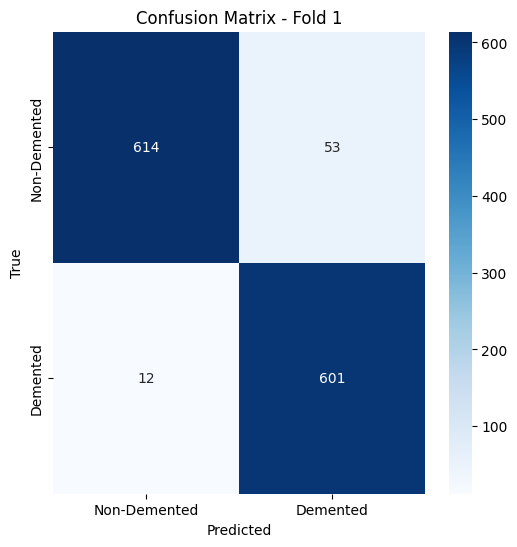

Epoch 1/10
160/160 [==============================] - 4s 19ms/step - loss: 0.6456 - accuracy: 0.6303 - val_loss: 0.5589 - val_accuracy: 0.7398
Epoch 2/10
160/160 [==============================] - 3s 16ms/step - loss: 0.5669 - accuracy: 0.7250 - val_loss: 0.5224 - val_accuracy: 0.7578
Epoch 3/10
160/160 [==============================] - 3s 16ms/step - loss: 0.4885 - accuracy: 0.7635 - val_loss: 0.4188 - val_accuracy: 0.8070
Epoch 4/10
160/160 [==============================] - 3s 16ms/step - loss: 0.3986 - accuracy: 0.8129 - val_loss: 0.3474 - val_accuracy: 0.8453
Epoch 5/10
160/160 [==============================] - 3s 16ms/step - loss: 0.2857 - accuracy: 0.8785 - val_loss: 0.2331 - val_accuracy: 0.9055
Epoch 6/10
160/160 [==============================] - 3s 16ms/step - loss: 0.1859 - accuracy: 0.9283 - val_loss: 0.1874 - val_accuracy: 0.9258
Epoch 7/10
160/160 [==============================] - 3s 16ms/step - loss: 0.1254 - accuracy: 0.9514 - val_loss: 0.1187 - val_accuracy: 0.9547

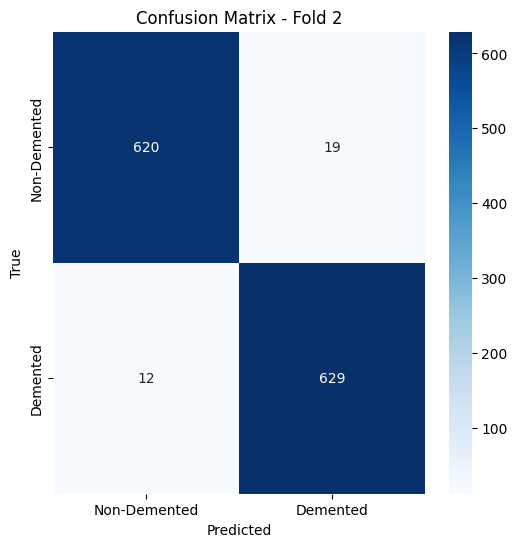

Epoch 1/10
160/160 [==============================] - 5s 19ms/step - loss: 0.6635 - accuracy: 0.5902 - val_loss: 0.6222 - val_accuracy: 0.6570
Epoch 2/10
160/160 [==============================] - 3s 17ms/step - loss: 0.5869 - accuracy: 0.7039 - val_loss: 0.5548 - val_accuracy: 0.7242
Epoch 3/10
160/160 [==============================] - 3s 16ms/step - loss: 0.5503 - accuracy: 0.7303 - val_loss: 0.5282 - val_accuracy: 0.7391
Epoch 4/10
160/160 [==============================] - 3s 16ms/step - loss: 0.4803 - accuracy: 0.7637 - val_loss: 0.5082 - val_accuracy: 0.7484
Epoch 5/10
160/160 [==============================] - 3s 16ms/step - loss: 0.4257 - accuracy: 0.7914 - val_loss: 0.4074 - val_accuracy: 0.8008
Epoch 6/10
160/160 [==============================] - 3s 16ms/step - loss: 0.3494 - accuracy: 0.8486 - val_loss: 0.3874 - val_accuracy: 0.8102
Epoch 7/10
160/160 [==============================] - 3s 16ms/step - loss: 0.2739 - accuracy: 0.8795 - val_loss: 0.2674 - val_accuracy: 0.8875

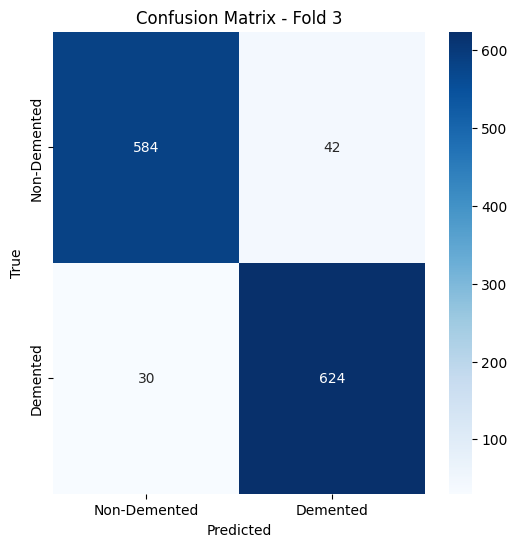

Epoch 1/10
160/160 [==============================] - 4s 19ms/step - loss: 0.6520 - accuracy: 0.6053 - val_loss: 0.5900 - val_accuracy: 0.6953
Epoch 2/10
160/160 [==============================] - 3s 16ms/step - loss: 0.5620 - accuracy: 0.7135 - val_loss: 0.5492 - val_accuracy: 0.7023
Epoch 3/10
160/160 [==============================] - 3s 16ms/step - loss: 0.4724 - accuracy: 0.7732 - val_loss: 0.4457 - val_accuracy: 0.7750
Epoch 4/10
160/160 [==============================] - 3s 16ms/step - loss: 0.3753 - accuracy: 0.8240 - val_loss: 0.3579 - val_accuracy: 0.8203
Epoch 5/10
160/160 [==============================] - 3s 16ms/step - loss: 0.2929 - accuracy: 0.8699 - val_loss: 0.2973 - val_accuracy: 0.8602
Epoch 6/10
160/160 [==============================] - 3s 16ms/step - loss: 0.1998 - accuracy: 0.9170 - val_loss: 0.2546 - val_accuracy: 0.9102
Epoch 7/10
160/160 [==============================] - 3s 16ms/step - loss: 0.1376 - accuracy: 0.9467 - val_loss: 0.1638 - val_accuracy: 0.9414

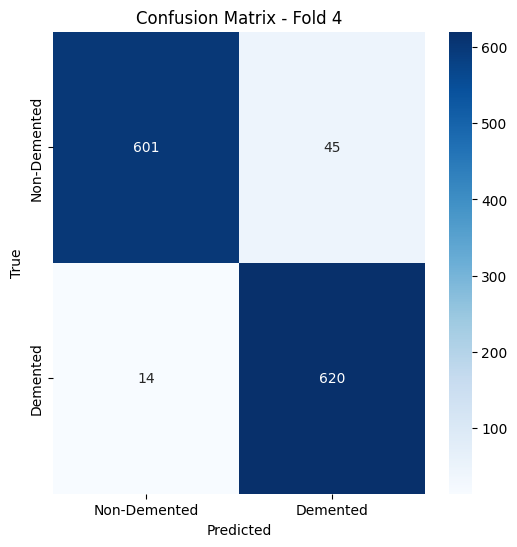

Epoch 1/10
160/160 [==============================] - 5s 19ms/step - loss: 0.6735 - accuracy: 0.5789 - val_loss: 0.6188 - val_accuracy: 0.6602
Epoch 2/10
160/160 [==============================] - 3s 16ms/step - loss: 0.5876 - accuracy: 0.6945 - val_loss: 0.5322 - val_accuracy: 0.7398
Epoch 3/10
160/160 [==============================] - 3s 16ms/step - loss: 0.5412 - accuracy: 0.7283 - val_loss: 0.5350 - val_accuracy: 0.7172
Epoch 4/10
160/160 [==============================] - 3s 16ms/step - loss: 0.4840 - accuracy: 0.7623 - val_loss: 0.4199 - val_accuracy: 0.7961
Epoch 5/10
160/160 [==============================] - 3s 16ms/step - loss: 0.4008 - accuracy: 0.8156 - val_loss: 0.3985 - val_accuracy: 0.8008
Epoch 6/10
160/160 [==============================] - 3s 16ms/step - loss: 0.3189 - accuracy: 0.8631 - val_loss: 0.2831 - val_accuracy: 0.8797
Epoch 7/10
160/160 [==============================] - 3s 16ms/step - loss: 0.2273 - accuracy: 0.9100 - val_loss: 0.2262 - val_accuracy: 0.9039

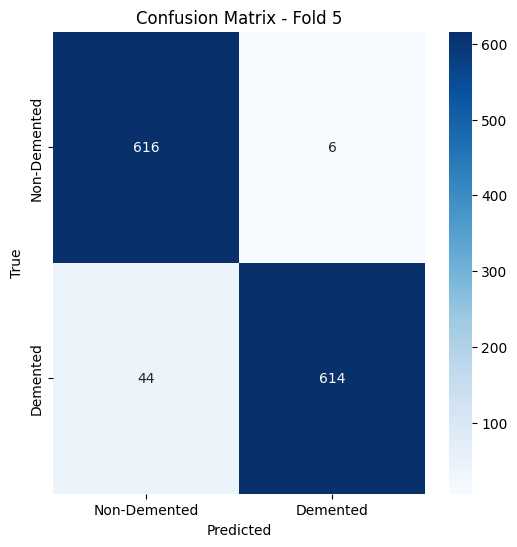

Average Cross-Validation Accuracy: 95.67%


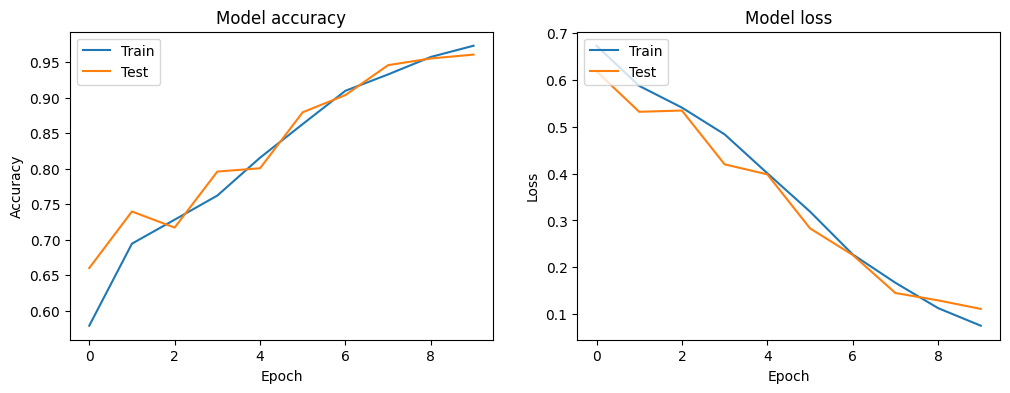

In [13]:
# combine all demented labels into a single class
non_demented_labels = np.zeros(non_demented.shape[0])
demented_labels = np.ones(very_mild_demented.shape[0] + mild_demented.shape[0] + moderate_demented.shape[0])

# training data and labels
X = np.concatenate((non_demented, very_mild_demented, mild_demented, moderate_demented), axis=0)
y = np.concatenate((non_demented_labels, demented_labels), axis=0)

# add a dimension 
if len(X.shape) == 3:
    X = np.expand_dims(X, axis = -1)

# normalization
X = X / 255.0

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    # train test splits
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    y_train = to_categorical(y_train, num_classes=2)
    y_test = to_categorical(y_test, num_classes=2)

    # architecture as discussed
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])

    # train model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

    # get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(classification_report(y_true, y_pred_classes))
    print(confusion_matrix(y_true, y_pred_classes))

    # plot confusion matrices
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Demented', 'Demented'], yticklabels=['Non-Demented', 'Demented'])
    plt.title(f'Confusion Matrix - Fold {i+1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    cv_results.append(accuracy)


average_accuracy = np.mean(cv_results)
print(f'Average Cross-Validation Accuracy: {average_accuracy * 100:.2f}%')


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

### Results

As seen above, our model produced ~95.67% accuracy across all folds, showing that  the model generalized well to ***our*** data
Other metrics: F1, precision, accuracy all had similar results as shown through the confusion matrices for each fold.
Because we addressed the class imbalance, we opted to still look at accuracy as the main evaluation metric, and it was far above the baseline which was random guessing.

# Conclusion & Discussion (Limitations, Additional Experiments, Future Work)

Reflecting on our process from the proposal to the finished analysis, a lot has changed. First, we realized we didn't need to perform K-Means clustering for labelling classes and thus could focus more on making a model that fit the data well without overfitting. Additionally, the evaluation metrics we would have used such as Silhoutte score, Dunn Index, and other unsupervised metrics were not as important as accuracy and metrics related to classification / ones from confusion matrices.

Our analysis demonstrated that the model achieved approximately 95.67% accuracy across all folds, indicating robust generalization to our data. Other metrics, such as F1 score, precision, and accuracy, also showed similarly strong results, as evidenced by the confusion matrices for each fold. Despite addressing class imbalance, accuracy remained our primary evaluation metric and significantly exceeded the baseline of random guessing. These results address our initial question of if it is possible to use computer vision methods to predict / classify Alzheimer's disease. Additionally they support our hypothesis that we can produce a model that performs better than random guessing.

In discussing the results, it's clear that our model effectively answered our experimental question regarding its ability to classify images accurately. However, there are limitations to our analysis, primarily the simplicity and size of our dataset. To enhance the robustness and generalizability of our model, future work could include gathering more diverse data and experimenting with data augmentation techniques such as flipping, rotating, and cropping. Although we hypothesize that the model would still perform well with augmented data, it is not guaranteed to reach the same level of accuracy. Additionally, exploring transfer learning and fine-tuning an existing fMRI CNN model could provide valuable insights and further improve performance.